In [1]:
# Deep Learning with Python Ch3: Boston example
# import necessary libraries
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras.datasets import boston_housing
from keras import models
from keras import layers

Using TensorFlow backend.


In [2]:
# load data
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
# normalize data
mean = train_data.mean(axis=0)
std  = train_data.std(axis=0)

x_train = (train_data - mean) / std
x_test  = (test_data - mean) / std

# check
print(x_train.mean(axis=0))
print(x_train.std(axis=0))

[-1.01541438e-16  1.09923072e-17  1.74337992e-15 -1.26686340e-16
 -5.25377321e-15  6.41414864e-15  2.98441140e-16  4.94653823e-16
  1.12671149e-17 -1.98136337e-16  2.36686358e-14  5.95679996e-15
  6.13920356e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [4]:
# build network
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [6]:
# K-fold CV and save validation logs at each fold
num_fold  = 4
num_cv    = len(x_train)//num_fold
num_epoch = 400
mae_hist  = []

for i in range(num_fold):
    print('processing fold #', i+1)
    
    # validation data
    x_val = x_train[i*num_cv : (i+1)*num_cv]
    y_val = train_targets[i*num_cv : (i+1)*num_cv]
    
    # training data
    x_part = np.concatenate([x_train[:i*num_cv], x_train[(i+1)*num_cv:]], axis=0)
    y_part = np.concatenate([train_targets[:i*num_cv], train_targets[(i+1)*num_cv:]], axis=0)
    
    # train model
    model   = build_model()
    history = model.fit(x_part, y_part, validation_data=(x_val, y_val), 
                        epochs=num_epoch, batch_size=1, verbose=0)
    mae_hist.append(history.history['val_mean_absolute_error'])

processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


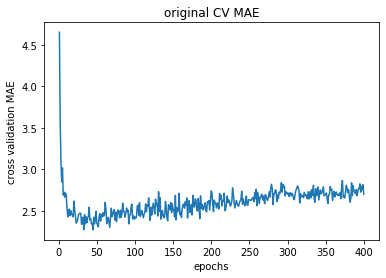

In [7]:
# plot CV MAE
avg_mae_hist = [np.mean([x[i] for x in mae_hist]) for i in range(num_epoch)]

plt.plot(range(1, len(avg_mae_hist)+1), avg_mae_hist)
plt.title('original CV MAE')
plt.xlabel('epochs')
plt.ylabel('cross validation MAE')
plt.show()

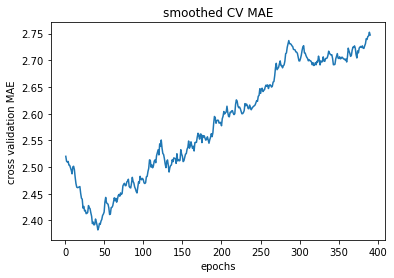

In [8]:
# smooth MAE plot
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points: # if smoothed_points has elements
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else: # if smoothed_points is empty
            smoothed_points.append(point)
    return smoothed_points

# drop the 1st 10 MAEs
smooth_mae_hist = smooth_curve(avg_mae_hist[10:])

# plot smoothed MAE
plt.plot(range(1,len(smooth_mae_hist)+1), smooth_mae_hist)
plt.title('smoothed CV MAE')
plt.xlabel('epochs')
plt.ylabel('cross validation MAE')
plt.show()

In [9]:
# retrain model using the whole training data
# start fresh
model = build_model()

# retrain
best_epoch = np.argmin(smooth_mae_hist)+10
model.fit(x_train, train_targets, epochs=best_epoch, batch_size=16, verbose=0)

# apply to test data
test_mse, test_mae = model.evaluate(x_test, test_targets)
print('test MSE:', test_mse)
print('test MAE:', test_mae)

102/102 [==============================] - 0s 1ms/step
test MSE: 19.633549409754135
test MAE: 2.7670655250549316
